In [1]:
import logging
import shlex
import sys
from pathlib import Path
from typing import Dict, Tuple, Union

import elettra_toolbox
from elettra_toolbox import ScanConfig
from cpymad.madx import Madx

LOGGER = logging.getLogger(name=__name__)
LOGGER.setLevel(logging.DEBUG)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
LOGGER.addHandler(handler)

import os
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from matplotlib import cm, gridspec, patches
from pyhdtoolkit import cpymadtools

plt.rcParams.update({"text.usetex": False})

In [2]:
if os.path.exists("stdout.out"):
    os.remove("stdout.out")

# Launch MAD-X Session
with open("stdout.out", "w") as f:
    madx = Madx(stdout=f)

# Read parameters

from config import parameters, settings

for i in parameters.keys():
    madx.globals[i] = parameters[i]

# Call sequence and optics

madx.call("elettra2_v15_VADER_2.3T.madx")
madx.call("optics_elettra2_v15_VADER_2.3T.madx")

# Initial twiss

madx.use(sequence="ring")
madx.twiss(sequence="ring", table="init_twiss")

# Compute Emittance

madx.input(
    f"""
emit, deltap={madx.globals.deltap};
emit, deltap={madx.globals.deltap};
"""
)

# Get the emittance from the standard output

ex, ey, ez = elettra_toolbox.get_emittances_from_madx_output("stdout.out", to_meters=True)


print(f"Emittance x : {ex*1e12} pm")

twiss = madx.table.init_twiss.dframe()


# Let's install some markers

madx.input(
    """
left_marker: marker;
right_marker: marker;
middle_marker: marker;

use, sequence=ring;
seqedit, sequence=ring;
flatten;
install, element=left_marker, at=10.8;
install, element=middle_marker, at=21.6;
install, element=right_marker, at=32.4;
flatten;
endedit;
"""
)

madx.use(sequence="ring")
madx.twiss(sequence="ring")
twiss = madx.table.twiss.dframe()

Emittance x : 1031.9436 pm


In [27]:
def compute_curly_H(madx: Madx) -> pd.DataFrame:
    '''
    This function computes the curly-H function and returns it in a Twiss DF. 
    
    Args:
        madx (Madx): running madx instance
    
    Returns
        twiss_df (pd.DataFrame): DataFrame containing the results of the TWISS command, together with the
                                    "curly_H" column of interest
    '''
    LOGGER.info('TWISS...')
    madx.twiss(table='twiss_curly_h');
    twiss_df = madx.table.twiss_curly_h.dframe()
    twiss_df['dx_p'] = twiss_df['dx'].diff()/twiss_df['s'].diff() #Computes the derivative of the dispersion with respedct to s
    LOGGER.info('Computing curly-H function...')
    twiss_df['curly_h'] = (twiss_df['dx']**2 + (twiss_df['betx']*twiss_df['dx_p'] + twiss_df['alfx']*twiss_df['dx'])**2)/twiss_df['betx']
    
    return twiss_df

In [28]:
twiss_df = compute_curly_H(madx)

TWISS...
Computing curly-H function...


(10.0, 33.0)

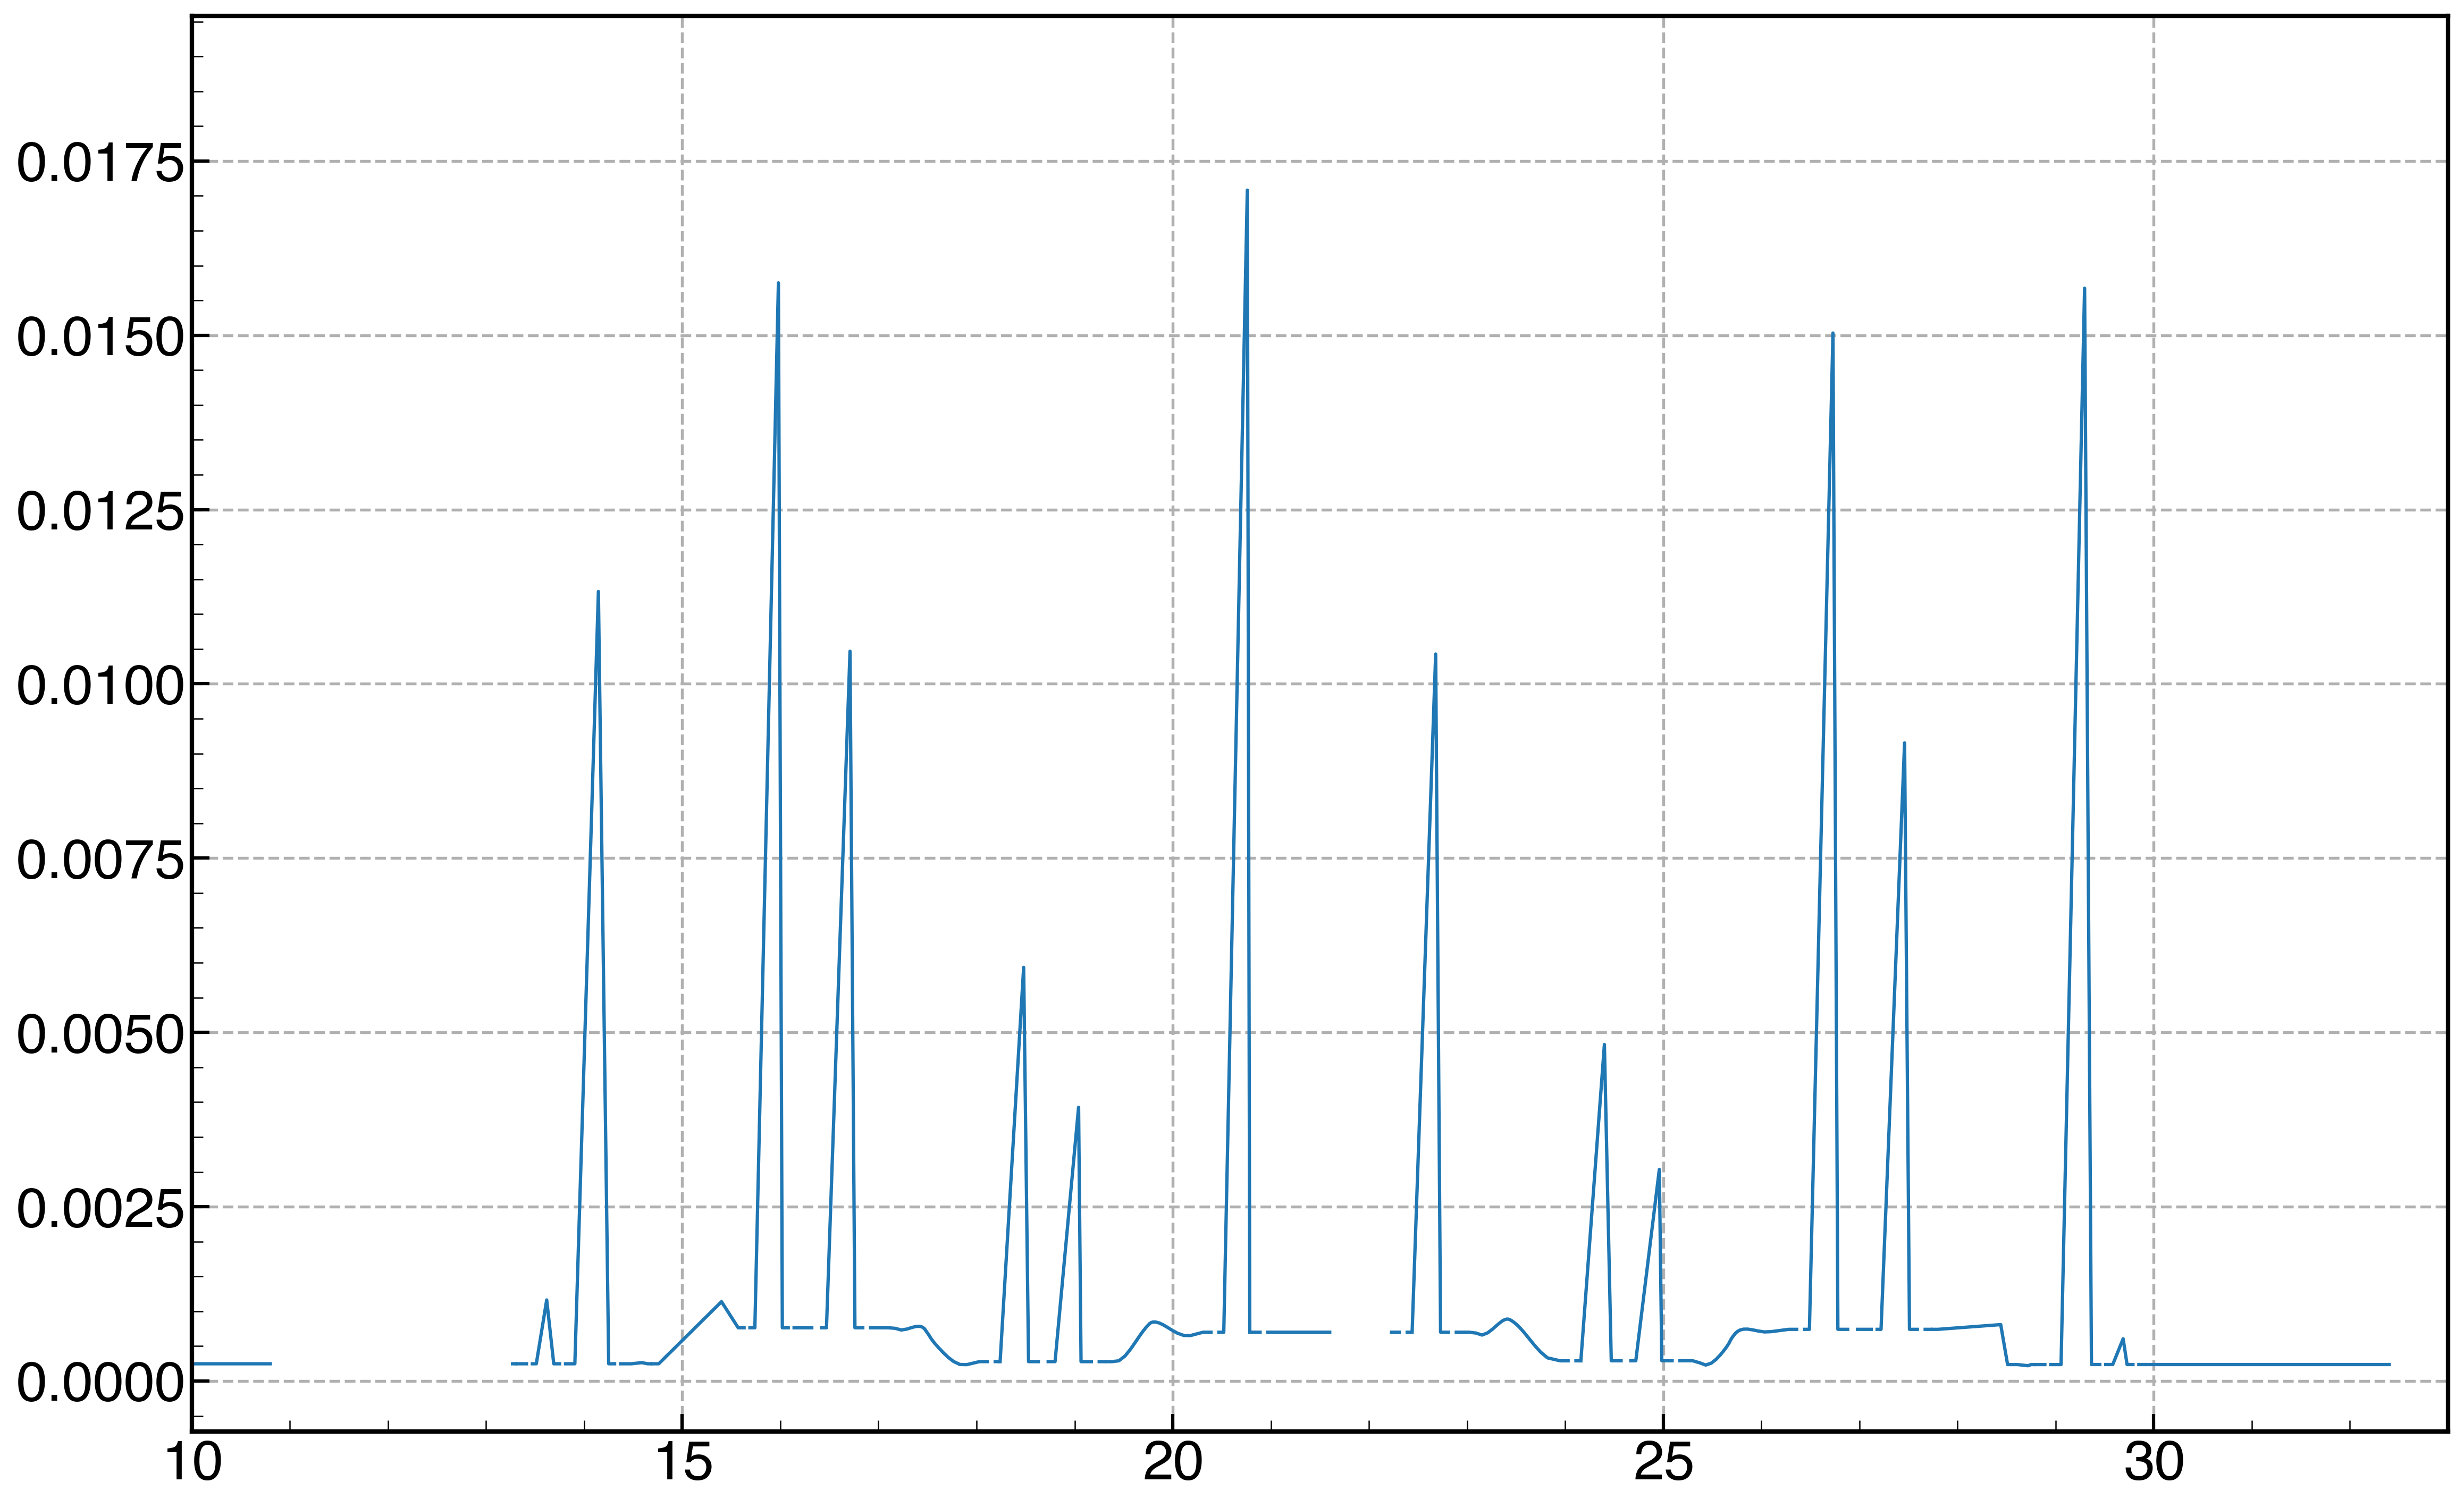

In [29]:
plt.plot(twiss_df['s'], twiss_df['curly_h'])
plt.xlim(10,33)

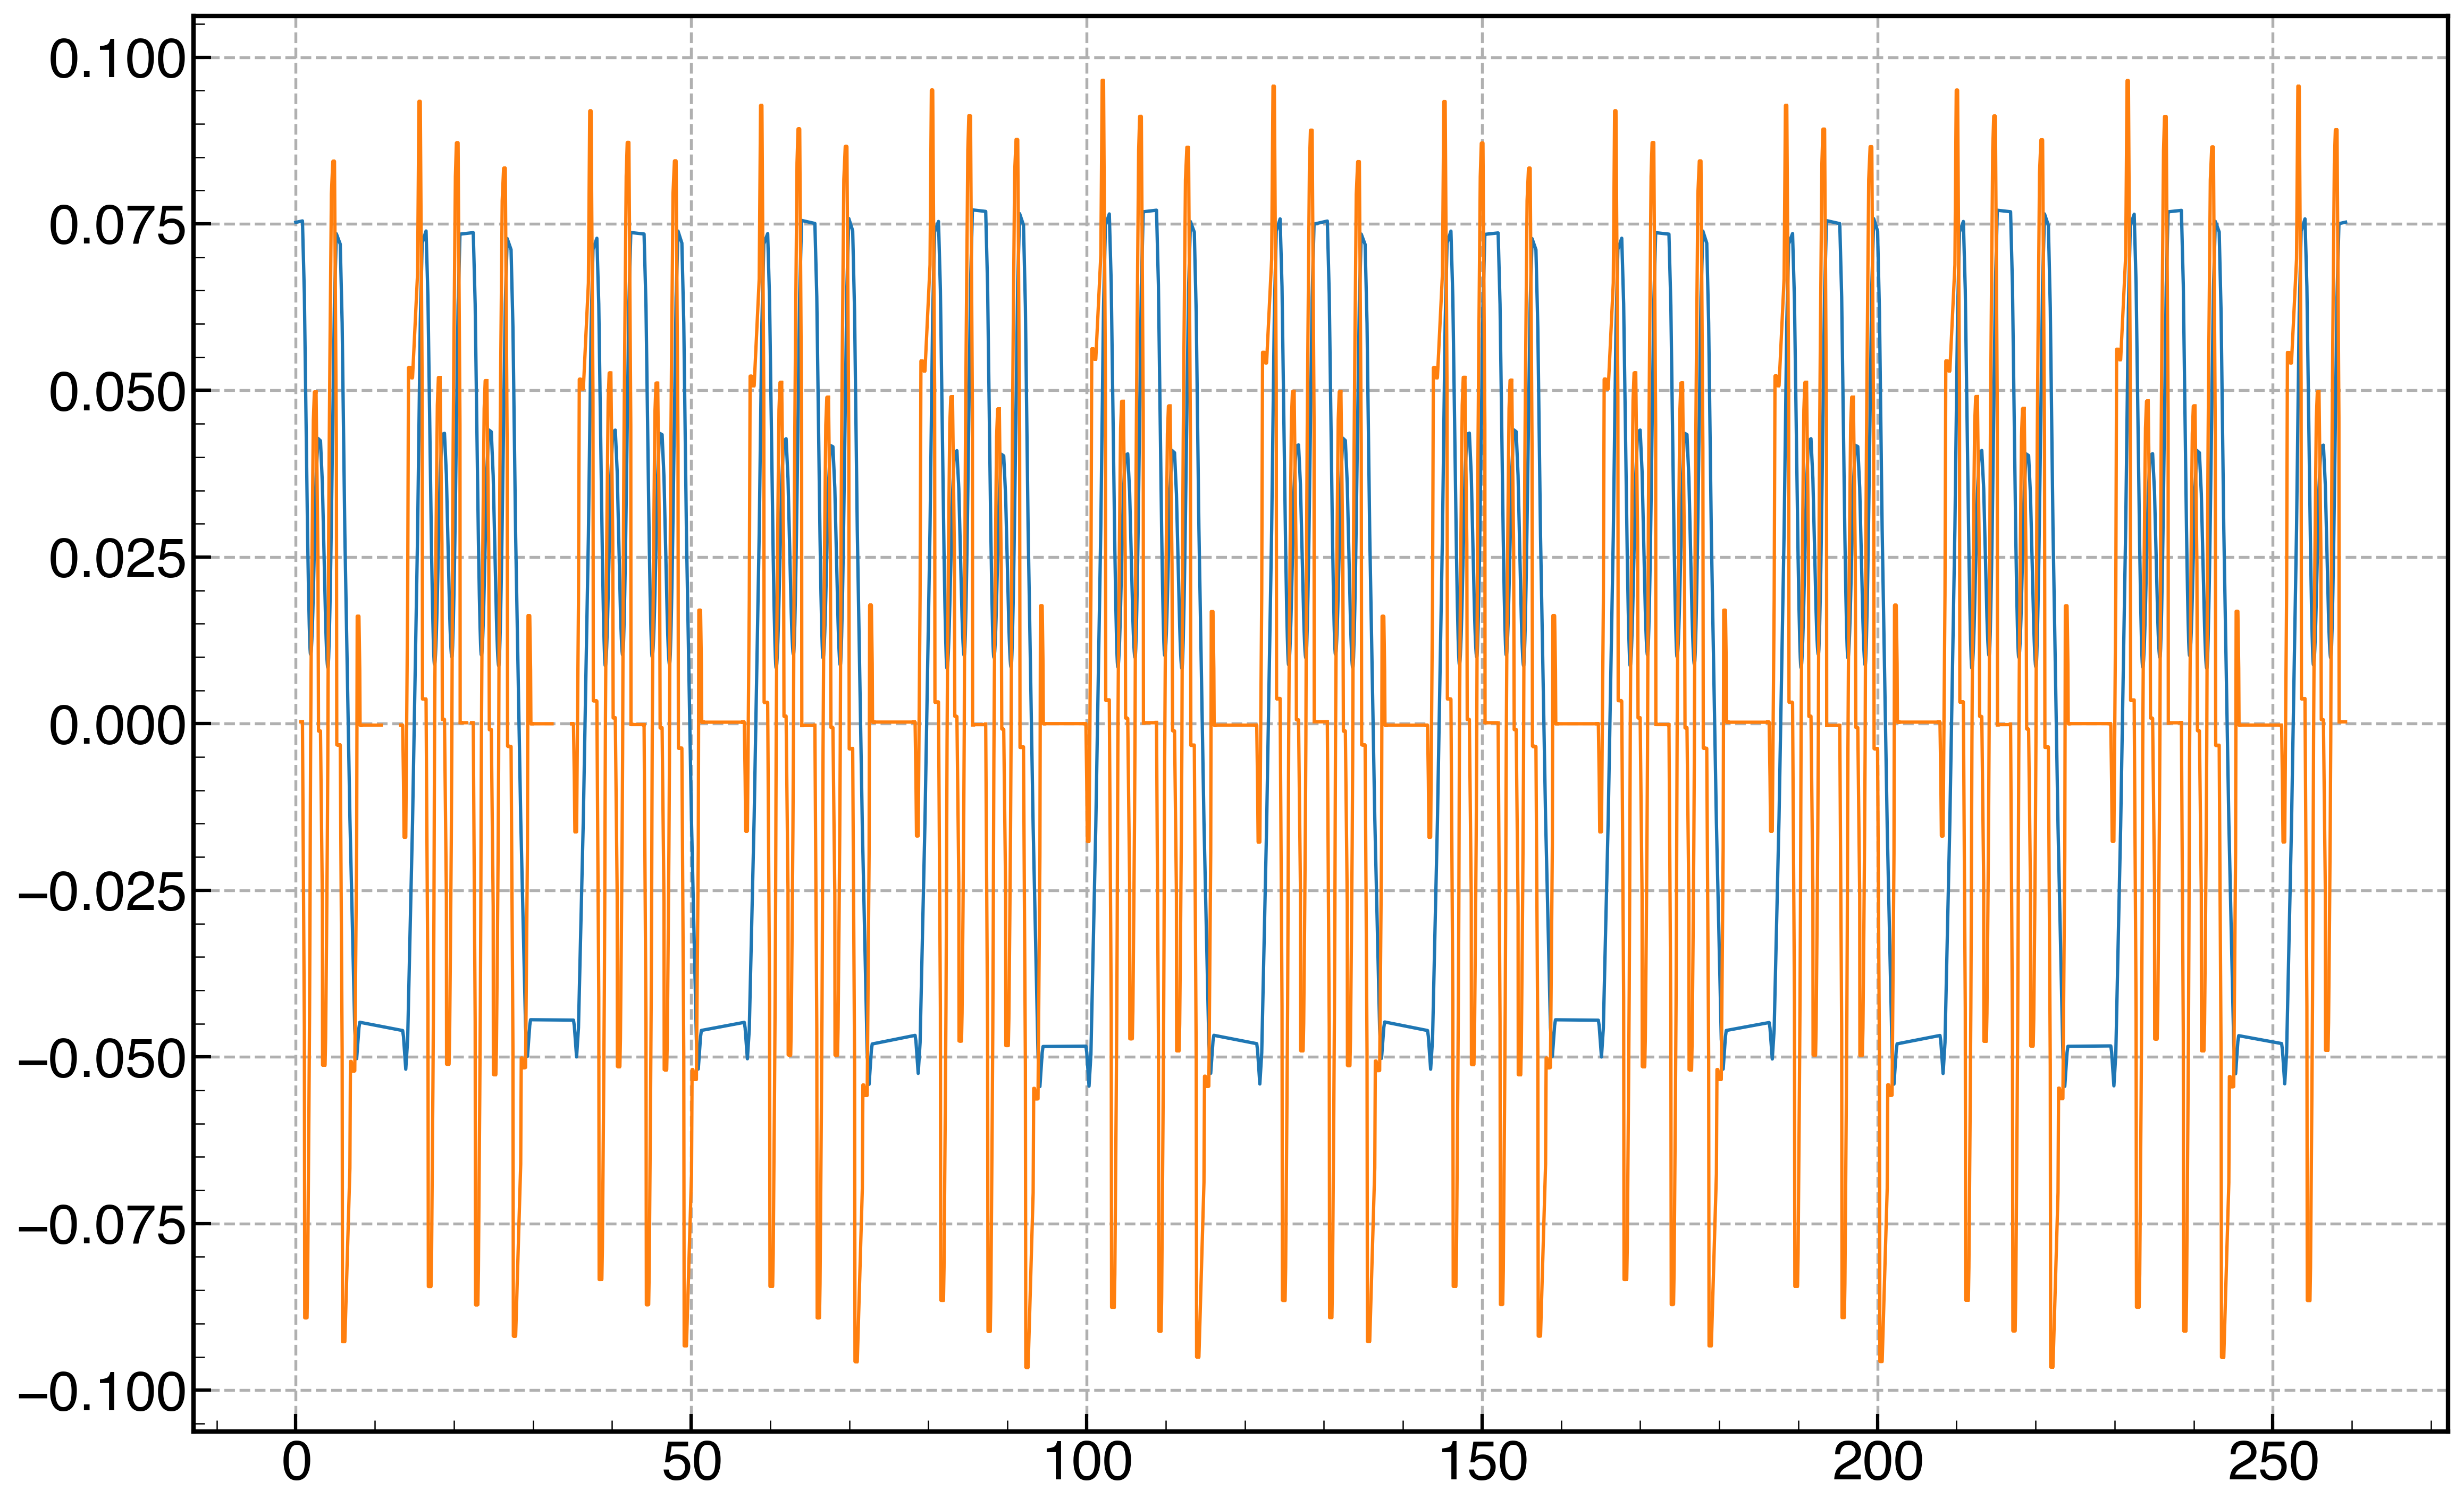

In [13]:
plt.plot(twiss_df['s'], twiss_df['dx'])
plt.plot(twiss_df['s'], twiss_df['dx_p'])

In [ ]:
def compute_curly_H(madx: Madx) -> pd.DataFrame: